# Graph Neural Network를 사용한 Semi-supervised Community Detection

딥러닝의 MNIST처럼, 그래프 도메인에서는 'Zachary의 카라테 클럽' 예제가 있습니다.
'카라테 클럽'은 소셜 네트워크로, 34명의 멤버와 클럽 외부에서 교류하는 멤버들 사이의 쌍별 관계를 담은 문서를 포함하고 있습니다.
이 클럽은 2개의 커뮤니티로 나뉘어, 지도자 (노드 0번)와 클럽 회장(노드 33번)가 각각 커뮤니티를 이끌게 됩니다.
네트워크는 아래처럼 시각화되며, 색상은 커뮤니티를 나타냅니다.


<img src='../asset/karat_club.png' align='center' width="400px" height="300px" />

In this tutorial, you will learn:
이 튜토리얼에서 배울 수 있는 것:


* 커뮤니티 감지 문제를 semi-supervised 노드 분류 태스크로 다룹니다.

* 모델을 학습하고 결과를 이해합니다.

GCN paper link : http://tkipf.github.io/graph-convolutional-networks/

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools

Using backend: pytorch


In [2]:
from tutorial_utils import load_zachery

# load graph
g = load_zachery()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


In [3]:
g.edges(form='uv', order='srcdst')

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  

In [5]:
# node features
node_embed = nn.Embedding(g.number_of_nodes(), 5)  
inputs = node_embed.weight
nn.init.xavier_uniform_(inputs)
print(inputs)

g.ndata['feature'] = inputs

Parameter containing:
tensor([[ 0.1609,  0.2994,  0.0862, -0.1299, -0.1925],
        [-0.2698,  0.2573, -0.1219, -0.2004, -0.0643],
        [ 0.2771, -0.0066,  0.3116, -0.1531, -0.3219],
        [ 0.2106, -0.3340,  0.3541,  0.3894,  0.2615],
        [-0.1125,  0.2388,  0.1128, -0.3154, -0.3767],
        [ 0.1646,  0.2906, -0.3849, -0.1865,  0.3179],
        [-0.0018,  0.3525,  0.0938,  0.1366, -0.2184],
        [-0.1666,  0.0290, -0.1742,  0.2775, -0.0347],
        [-0.3805, -0.0581, -0.3699,  0.3037, -0.1524],
        [-0.3711, -0.1460, -0.0839,  0.1760,  0.1244],
        [-0.3420,  0.0899,  0.0194, -0.3328,  0.0764],
        [ 0.3616, -0.3307,  0.2263,  0.3022,  0.0213],
        [-0.0700,  0.0668,  0.2942,  0.3632,  0.1350],
        [ 0.0978,  0.0575,  0.3315, -0.3027,  0.1104],
        [-0.1979, -0.0397, -0.1583, -0.2956,  0.0684],
        [-0.3823, -0.1902, -0.2878, -0.2728,  0.0976],
        [ 0.3479, -0.1297, -0.0432,  0.1488,  0.2120],
        [-0.2468, -0.0445, -0.0633, -0.1501

In [6]:
labels = g.ndata['club']
labeled_nodes = [0, 33]
print('Labels', labels[labeled_nodes])

Labels tensor([0, 1])


In [7]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### GCN

In [14]:
from dgl.nn import GraphConv

# create model 
# 2개의 레이어를 가진 GraphSAGE 모델 구축

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, 'both', allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, num_classes, 'both', allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# 주어진 차원의 모델 생성
# 인풋 레이어 차원: 5, feature 갯수로 생각 가능
# 히든 레이어 차원: 16, Embedding (또는 filter 개수)
# 아웃풋 레이어 차원: 2, 클래스가 2개 있기 때문, 0과 1

GCN_net = GCN(5, 16, 2)

In [15]:
import torch.nn.functional as F

# set up loss and optimizer

optimizer = torch.optim.Adam(itertools.chain(GCN_net.parameters(), node_embed.parameters()), lr=0.01)

# training
all_logits = []
for e in range(50):
    # forward
    logits = GCN_net(g, inputs)

    # 손실 계산
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp, labels)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
        print(logits)
        print(loss)


In epoch 0, loss: 0.6882094740867615
tensor([[-0.2569,  0.2256],
        [-0.1939,  0.1463],
        [-0.1845,  0.2177],
        [-0.0878,  0.1172],
        [-0.1737,  0.0994],
        [-0.2115,  0.0965],
        [-0.2073,  0.1205],
        [-0.1007,  0.1181],
        [-0.1399,  0.1683],
        [-0.0669,  0.1004],
        [-0.1688,  0.1270],
        [-0.0785,  0.1023],
        [-0.1149,  0.1255],
        [-0.1286,  0.1665],
        [-0.1236,  0.1708],
        [-0.1236,  0.1708],
        [-0.1253,  0.0563],
        [-0.0770,  0.1097],
        [-0.1236,  0.1708],
        [-0.1127,  0.1682],
        [-0.1236,  0.1708],
        [-0.0770,  0.1097],
        [-0.1236,  0.1708],
        [-0.1604,  0.2980],
        [-0.0753,  0.2831],
        [-0.0992,  0.2883],
        [-0.1220,  0.1982],
        [-0.1168,  0.2159],
        [-0.0736,  0.2029],
        [-0.1798,  0.2303],
        [-0.1228,  0.1867],
        [-0.1702,  0.2842],
        [-0.1865,  0.2710],
        [-0.2467,  0.3030]], grad_fn=<A

In [16]:
# ----------- 5. check results ------------------------ #
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 1.0


In [17]:
GCN_net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[-0.5866, -0.0348,  0.2212, -0.6022, -0.2302,  0.2737, -0.4882,  0.7678,
                        0.7397, -0.6907,  0.1411,  0.7312,  0.4369,  0.4047, -0.4811,  0.4641],
                      [ 0.2220, -0.1645,  0.1450,  0.4390,  0.2026, -0.6260,  0.7717, -0.8011,
                        0.0747,  0.7183, -0.1190, -0.6670,  0.1066, -0.2352,  0.5311, -0.6892],
                      [-0.3556, -0.3052,  0.1471, -0.6450,  0.2865,  0.7119, -0.6765,  0.4292,
                        0.4342, -0.0537,  0.6558, -0.2354, -0.2284,  0.4967, -0.2103,  0.0069],
                      [ 0.7997,  0.8052, -0.5594, -0.1854, -0.4590, -0.4793,  0.0329, -0.4014,
                       -0.5521,  0.2225, -0.1426,  0.1369, -0.3374, -0.2985,  0.4659, -0.8050],
                      [-0.1494, -0.5378, -0.3755, -0.5370,  0.1319,  0.4319, -0.0335,  0.6193,
                        0.6843,  0.0966, -0.2089,  0.7637, -0.2366,  0.5907, -0.8247,  0.3508]])),
            

### inference_test

In [49]:
src_ids = [1, 2, 2, 3, 3, 4, 4, 5]
dst_ids = [2, 1, 3, 2, 4, 3, 5, 4]
g_sub = dgl.graph((src_ids, dst_ids))

In [33]:
g_sub

Graph(num_nodes=6, num_edges=8,
      ndata_schemes={}
      edata_schemes={})

In [50]:
g_sub.ndata['feature'] = g.ndata['feature'][15:21, :]

In [51]:
g_sub

Graph(num_nodes=6, num_edges=8,
      ndata_schemes={'feature': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={})

In [52]:
GCN_net(g_sub, g_sub.ndata['feature'])

tensor([[ 0.2940, -0.2940],
        [ 0.1607,  0.3388],
        [ 8.1078, -6.0514],
        [-3.0401,  3.3381],
        [ 6.9949, -5.1713],
        [-4.2878,  4.2099]], grad_fn=<AddBackward0>)

In [57]:
pred = torch.argmax(GCN_net(g_sub, g_sub.ndata['feature']), axis=1)
pred

tensor([0, 1, 0, 1, 0, 1])

In [56]:
labels[15:21]

tensor([1, 0, 0, 1, 0, 1])

In [408]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [280]:
# 약간의 셋팅을 합니다. 이 셀은 무시하셔도 됩니다.
import matplotlib.pyplot as plt

# 외부 모듈의 자동 reloading
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # 플롯의 기본 사이즈 설정
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
len(all_logits)

50

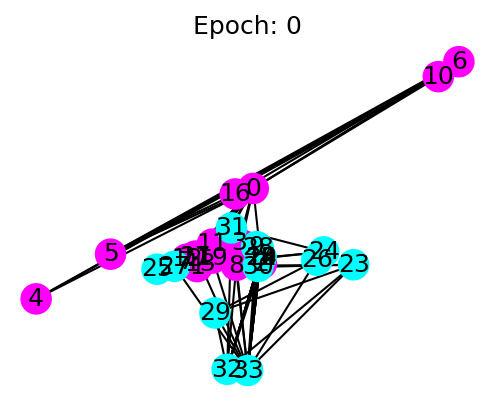

In [282]:
# 노드 분류를 로짓 출력을 사용해 시각화합니다. ffmpeg가 필요합니다.
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i].numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

In [146]:
from dgl.nn import SAGEConv

# create model
# 2개의 레이어를 가진 GraphSAGE 모델 구축

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# 주어진 차원의 모델 생성
# 인풋 레이어 차원: 5, feature 갯수
# 히든 레이어 차원: 16
# 아웃풋 레이어 차원: 2, 클래스가 2개 있기 때문, 0과 1

net = GraphSAGE(5, 16, 2)

In [283]:
# optimizer
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), node_embed.parameters()), lr=0.01)

# Training
all_logits = []
for e in range(100):
    # forward
    logits = net(g, g.ndata['feature'])

    # 손실 계산
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp, labels)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
#         print(logits)

In epoch 0, loss: 0.6491512060165405
In epoch 5, loss: 0.29910171031951904
In epoch 10, loss: 0.14864014089107513
In epoch 15, loss: 0.07212461531162262
In epoch 20, loss: 0.038800351321697235
In epoch 25, loss: 0.024479495361447334
In epoch 30, loss: 0.016010530292987823
In epoch 35, loss: 0.011303995735943317
In epoch 40, loss: 0.007946179248392582
In epoch 45, loss: 0.0055170124396681786
In epoch 50, loss: 0.003949938807636499
In epoch 55, loss: 0.0029421246144920588
In epoch 60, loss: 0.002265702933073044
In epoch 65, loss: 0.00180395832285285
In epoch 70, loss: 0.0014830235159024596
In epoch 75, loss: 0.0012581262271851301
In epoch 80, loss: 0.001089773140847683
In epoch 85, loss: 0.0009588217944838107
In epoch 90, loss: 0.0008567717159166932
In epoch 95, loss: 0.0007730934885330498


In [284]:
# ----------- 5. check results ------------------------ #
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 1.0
